## **Estudio de la criminalidad en México, año 2017**


In [1]:
# Librerías a utilizar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import statistics
import tensorflow as tf
import keras
# from sklearn.linear_model import LogisticRegression
# from sklearn import linear_model
# from sklearn import metrics
# from sklearn.model_selection import train_test_split



# from sklearn.preprocessing import OneHotEncoder
# import sklearn.preprocessing


# Para hacer curvas de aprendizaje
# from sklearn.model_selection import learning_curve

# Para hacer curvas de validación
# from sklearn.model_selection import validation_curve

# plt.rcParams['figure.figsize'] = (10, 10)
# plt.style.use('ggplot')
# %matplotlib inline

In [2]:
# Se importan las funciones necesarias
from sklearn import preprocessing                    #función para pre-procesar los datos     
from sklearn.model_selection import train_test_split #función que separa los datos aleatoriamente en arreglos train/test
from sklearn.preprocessing import MinMaxScaler       #función de rescalamiento de datos segun un factor dado
from sklearn.preprocessing import Normalizer         #función de normalizacion
from keras.models import Sequential                  #modelo secuencial de keras
from keras.layers.core import Dense                  #función para añadir otra capa en keras
from keras.layers import Dropout                     #función para corregir el sobreaprendizaje
from tensorflow.keras.callbacks import EarlyStopping #función que permite detener el algoritmo si no se percibe un progreso medido con ciertos parametros
from keras.utils import np_utils

Los datos a utilizar fueron obtenidos de la base de datos de la **Encuesta Nacional de Victimización y Percepción sobre Seguridad Pública (ENVIPE) 2018**, del Instituto Nacional de Estadística y Geografía (INEGI), la cual contiene información sobre las encuestas realizadas a la población mexicana en el año 2017, concerniente a los delitos de los cuales han sido víctimas. La tabla de datos a utilizar es la "Tabla del módulo sobre victimización" **(TMod_Vic)**, que se puede encontrar [aquí](https://www.inegi.org.mx/app/buscador/default.html?q=envipe+2018) (sitio de INEGI), o [aquí](https://github.com/BrayanRamirezCamacho/Seminario_de_Fisica_Computacional/tree/main/1_Evaluacion_Parcial) (Github personal).

In [3]:
# Lectura del archivo desde un repositorio de Github
url = 'https://raw.githubusercontent.com/BrayanRamirezCamacho/Seminario_de_Fisica_Computacional/main/1_Evaluacion_Parcial/TMod_Vic.csv'
victimas = pd.DataFrame(pd.read_csv(url))

# Muestra los primeros renglones del archivo
victimas.head()

,"ID_VIV,C,10","ID_HOG,C,13","ID_PER,C,16","ID_DEL,C,21","UPM,C,7","VIV_SEL,C,7","HOGAR,C,5","ND_TIPO,C,7","TD_TIPO,C,7","BPCOD,C,5","R_SEL,C,5","RESUL_H,C,7","SEXO,C,4","EDAD,C,4","AREAM_OCU,C,9","BP1_1,C,5","BP1_2C,C,6","BP1_3C,C,6","BP1_4,C,5","BP1_5,C,5","BP1_6,C,5","BP1_7,C,5","BP1_8,C,5","BP1_9,C,5","BP1_10_1,C,8","BP1_10_2,C,8","BP1_10_9,C,8","BP1_11,C,6","BP1_12_1,C,8","BP1_12_2,C,8","BP1_12_3,C,8","BP1_12_4,C,8","BP1_12_5,C,8","BP1_12_9,C,8","BP1_13,C,6","BP1_14_1,C,8","BP1_14_2,C,8","BP1_14_3,C,8","BP1_14_4,C,8","BP1_14_9,C,8",...,"BP1_36_05,C,9","BP1_36_06,C,9","BP1_36_07,C,9","BP1_36_08,C,9","BP1_36_09,C,9","BP1_36_10,C,9","BP1_36_11,C,9","BP1_36_99,C,9","BP2_1,C,5","BP3_1_01,C,8","BP3_1_02,C,8","BP3_1_03,C,8","BP3_1_04,C,8","BP3_1_05,C,8","BP3_1_06,C,8","BP3_1_07,C,8","BP3_1_08,C,8","BP3_1_09,C,8","BP3_1_10,C,8","BP3_1_11,C,8","BP3_1_12,C,8","BP3_1_99,C,8","BP3_2,C,5","BP4_1,C,5","BP5_1,C,5","BP5_2_1,C,7","BP5_2_2,C,7","BP5_2_3,C,7","BP5_2_4,C,7","BP5_3,C,5","BP6_1,C,5","BP6_2,C,5","BP6_3,C,5","BP7_1,C,5","FAC_DEL,C,7","FAC_DEL_AM,C,10","DOMINIO,C,7","ESTRATO,C,7","EST_DIS,C,7","UPM_DIS,C,7"
0,100721.03,0100721.03.01,0100721.03.01.03,0100721.03.01.03.02.2,100721,3,1,2,5,2,3,A,1,31,14.0,4,1,1,4,1,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,201,201.0,U,3,2,79
1,100721.03,0100721.03.01,0100721.03.01.03,0100721.03.01.03.01.1,100721,3,1,1,1,1,3,A,1,31,14.0,10,1,1,3,1,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,201,201.0,U,3,2,79
2,100721.03,0100721.03.01,0100721.03.01.03,0100721.03.01.03.02.3,100721,3,1,3,5,2,3,A,1,31,14.0,5,1,1,2,1,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,201,201.0,U,3,2,79
3,100721.03,0100721.03.01,0100721.03.01.03,0100721.03.01.03.11.1,100721,3,1,1,1,11,3,A,1,31,14.0,5,1,1,3,1,1.0,1.0,2.0,4.0,1.0,0.0,0.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,602,602.0,U,3,2,79
4,100721.03,0100721.03.01,0100721.03.01.03,0100721.03.01.03.07.1,100721,3,1,1,1,7,3,A,1,31,14.0,6,1,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,602,602.0,U,3,2,79


In [4]:
# Ver los tipos de datos que Pandas ha reconocido al leer
victimas.dtypes

ID_VIV,C,10        float64
ID_HOG,C,13         object
ID_PER,C,16         object
ID_DEL,C,21         object
UPM,C,7              int64
                    ...   
FAC_DEL_AM,C,10    float64
DOMINIO,C,7         object
ESTRATO,C,7          int64
EST_DIS,C,7          int64
UPM_DIS,C,7          int64
Length: 129, dtype: object

# Selección de las varibales de interés

Se consulta el [catálogo de variables](https://www.inegi.org.mx/app/biblioteca/ficha.html?upc=702825104818) provisto por los autores, y las consideradas más relevantes se muestran a continuación:

**BPCOD,C,5:**
Códigos para delitos (Ésta será la variable de salida, o "target").

**SEXO,C,4:**
Sexo de la víctima.

**EDAD,C,4:**
Edad de la víctima.

**AREAM_OCU,C,9:**
Área metropolitana de ocurrencia (del delito).

**BP1_1,C,5:**
¿En qué mes del 2017 sucedió (el delito)?

**BP1_2C,C,6:**
¿En qué Estado sucedió (el delito)?

**BP1_4,C,5:**
¿Aproximadamente a qué hora se cometió (el delito)?

**BP1_5,C,5:**
¿En qué lugar sucedió (el delito)?


In [5]:
# Creación de un DataFrame con las columnas de interés
datos = victimas[['BPCOD,C,5','SEXO,C,4','EDAD,C,4','AREAM_OCU,C,9','BP1_1,C,5','BP1_2C,C,6','BP1_4,C,5','BP1_5,C,5']]
datos.head()

,"BPCOD,C,5","SEXO,C,4","EDAD,C,4","AREAM_OCU,C,9","BP1_1,C,5","BP1_2C,C,6","BP1_4,C,5","BP1_5,C,5"
0,2,1,31,14.0,4,1,4,1
1,1,1,31,14.0,10,1,3,1
2,2,1,31,14.0,5,1,2,1
3,11,1,31,14.0,5,1,3,1
4,7,1,31,14.0,6,1,1,1


Para trabajar con mayor facilidad, se cambiará el nombre de las variables

In [6]:
#Creación de nuevas columnas
datos[['DELITO']] = datos[['BPCOD,C,5']]
datos[['SEXO']] = datos[['SEXO,C,4']]
datos[['EDAD']] = datos[['EDAD,C,4']]
datos[['AREAM']] = datos[['AREAM_OCU,C,9']]
datos[['MES']] = datos[['BP1_1,C,5']]
datos[['ESTADO']] = datos[['BP1_2C,C,6']]
datos[['HORA']] = datos[['BP1_4,C,5']]
datos[['LUGAR']] = datos[['BP1_5,C,5']]

datos.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,"BPCOD,C,5","SEXO,C,4","EDAD,C,4","AREAM_OCU,C,9","BP1_1,C,5","BP1_2C,C,6","BP1_4,C,5","BP1_5,C,5",DELITO,SEXO,EDAD,AREAM,MES,ESTADO,HORA,LUGAR
0,2,1,31,14.0,4,1,4,1,2,1,31,14.0,4,1,4,1
1,1,1,31,14.0,10,1,3,1,1,1,31,14.0,10,1,3,1
2,2,1,31,14.0,5,1,2,1,2,1,31,14.0,5,1,2,1
3,11,1,31,14.0,5,1,3,1,11,1,31,14.0,5,1,3,1
4,7,1,31,14.0,6,1,1,1,7,1,31,14.0,6,1,1,1


In [7]:
#Eliminación de las viejas columnas
datos = datos.drop(columns=['BPCOD,C,5','SEXO,C,4','EDAD,C,4','AREAM_OCU,C,9','BP1_1,C,5','BP1_2C,C,6','BP1_4,C,5','BP1_5,C,5'])

datos.head()

,DELITO,SEXO,EDAD,AREAM,MES,ESTADO,HORA,LUGAR
0,2,1,31,14.0,4,1,4,1
1,1,1,31,14.0,10,1,3,1
2,2,1,31,14.0,5,1,2,1
3,11,1,31,14.0,5,1,3,1
4,7,1,31,14.0,6,1,1,1


In [8]:
# Ver los tipos de variables
datos.dtypes

DELITO      int64
SEXO        int64
EDAD        int64
AREAM     float64
MES         int64
ESTADO      int64
HORA        int64
LUGAR       int64
dtype: object

In [9]:
# Conteo de datos por atributo
datos.count()

DELITO    46674
SEXO      46674
EDAD      46674
AREAM     28084
MES       46674
ESTADO    46674
HORA      46674
LUGAR     46674
dtype: int64

Los posibles valores para cada variable simbolizan:

**DELITO:**
01- Robo total de vehículo
02- Robo de accesorios, refacciones o herramientas de vehículo
03- Pinta de barda en su casa, vandalismo
04- Robo a casa/departamento
05- Robo o asalto en la calle o transporte público
06- Robo distinto a la anterior
07- Fraude bancario, clonacion de cuentas de banco, fraude.
08- Fraude al consumidor
09- Extorsión telefonica
10- Amenazas verbales
11- Ataques violentos
12- Secuestro 
13- Hostigamiento Sexual
14- Violacion Sexual
15- Delitos distintos a los anteriores

**SEXO:**
1- Hombre
2- Mujer

**EDAD:**
Un entero con la edad del encuestado al momento del delito

**MES:**
01- Enero
02- Febrero
03- Marzo
04- Abril
05- Mayo
06- Junio
07- Julio
08- Agosto
09- Septiembre
10- Octubre
11- Noviembre
12- Diciembre
99- No sabe/ no responde

**ESTADO:**
01- Aguascalientes
02- Baja California 
03- Baja California Sur
04- Campeche 
05- Coahuila
06- Colima
07- Chiapas
08- Chihuahua
09- CDMX
10- Durango
11- Guanajuato
12- Guerrero
13- Hidalgo
14- Jalisco
15- Estado de México
16- Michoacán de Ocampo
17- Morelos
18- Nayarit
19- Nuevo León
20- Oaxaca
21- Puebla de Zaragoza
22- Querétaro
23- Quintana Roo
24- San Luis Potosi
25- Sinaloa
26- Sonora
27- Tabasco
28- Tamaulipas
29- Tlaxcala
30- Veracruz Llave
31- Yucatán
32- Zacatecas
99- No especificada

**HORA:**
1- En la mañana (de 06:01 a 12:00 hrs.)
2- En la tarde (de 12:01 a 18:00 hrs.)
3- En la noche (de 18:01 a 24:00 hrs.)
4- En la madrugada (de 00:01 a 06:00 hrs.)
9- No sabe/ no responde

**LUGAR:**
1- En la calle
2- En su casa
3- En su trabajo
4- En un negocio o establecimiento
5- En un lugar público
6- En el transporte público
7- En una carretera
8- Otro
9- No sabe/ no responde

Es necesario realizar una búsqueda de datos nulos o faltantes antes de continuar con el análisis

In [10]:
# Conteo de los datos nulos por columna
datos.isna().sum()

DELITO        0
SEXO          0
EDAD          0
AREAM     18590
MES           0
ESTADO        0
HORA          0
LUGAR         0
dtype: int64

In [11]:
print("Los datos faltantes en la variable 'AREAM' representan el " + str(np.round( (18590/46674)*100, decimals=2)) + "%" )

Los datos faltantes en la variable 'AREAM' representan el 39.83%


La información faltante sobre el área metropolitana no puede ser reemplazada artificialmente, por lo que se decide eliminar ésta variable. Se elimina también la columna **'DELITO'** para que el dataframe **"X"** represente a la matriz de diseño (la matriz con todas las muestras del vector de entrada).

In [12]:
X = datos.drop(columns=['AREAM','DELITO'])
#Se elimina también la columa 'DELITO' por tratarse de la variable objetivo o target.

# Matriz de correlación
Se utilizará la matriz de correlación para elaborar un mapa de calor ('heatmap'), y con ello estudiar la correlación entre las variables

In [13]:
#Se utiliza la funcion corr() para hallar correlaciones entre las variables
X_corr = X.corr(method='pearson', min_periods=1)
#Se muestra la matriz de correlación
X_corr.head()

,SEXO,EDAD,MES,ESTADO,HORA,LUGAR
SEXO,1.000000,0.003658,0.013734,0.006944,-0.026451,0.016895
EDAD,0.003658,1.000000,0.038796,-0.016785,-0.004603,-0.003803
MES,0.013734,0.038796,1.000000,-0.003812,0.069750,0.008251
ESTADO,0.006944,-0.016785,-0.003812,1.000000,-0.026364,0.028488
HORA,-0.026451,-0.004603,0.069750,-0.026364,1.000000,-0.004096


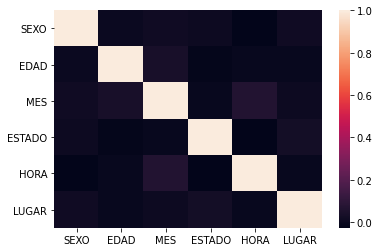

In [14]:
#Mapa de calor con las correlaciones
sb.heatmap( X_corr )

Aquí se observa que todas las variables están poco relacionadas entre sí, por lo que se decide no eliminar ninguna.

# Análisis exploratorio de los datos / Obtención de algunos estadísticos de interés

In [15]:
#Conteo de los datos por sexo
X['SEXO'].value_counts(normalize=True)
# 1 - Hombre
# 2 - Mujer

2    0.5006
1    0.4994
Name: SEXO, dtype: float64

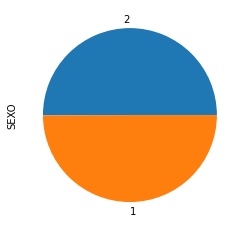

In [16]:
X['SEXO'].value_counts(normalize=True).plot.pie()

Dentro de la muestra, las mujeres (2) son víctimas en la mayoría de los casos, aunque la diferencia es muy pequeña.

In [17]:
#Conteo de los datos por mes (en porcentajes)
X['MES'].value_counts(normalize=True)

12    0.114582
11    0.108390
6     0.091721
10    0.081801
3     0.078888
5     0.077581
2     0.077474
9     0.075995
8     0.073638
7     0.069161
1     0.061233
4     0.060933
99    0.028603
Name: MES, dtype: float64

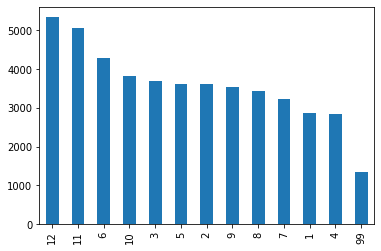

In [18]:
X['MES'].value_counts(normalize=False).plot.bar()

Diciembre y noviembre son los dos meses con mayor número de delitos cometidos, seguidos por junio y octubre.

In [19]:
# Conteo de datos por estado (en porcentaje)
X['ESTADO'].value_counts(normalize=True)

9     0.112547
21    0.053027
15    0.051592
2     0.041201
14    0.041008
17    0.039380
27    0.037366
22    0.036230
25    0.032588
12    0.031238
8     0.031174
19    0.030038
16    0.029031
1     0.028067
26    0.027510
23    0.027339
6     0.025496
11    0.025239
29    0.024832
3     0.024725
28    0.024575
5     0.023632
31    0.023525
10    0.023525
7     0.023225
4     0.020890
30    0.019540
13    0.019111
20    0.018640
32    0.018297
24    0.017483
18    0.016862
99    0.001071
Name: ESTADO, dtype: float64

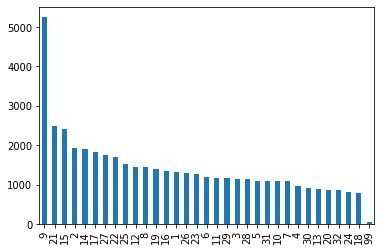

In [20]:
X['ESTADO'].value_counts(normalize=False).plot.bar()

La entidad federativa de mayor delincuencia es (por mucho) la Ciudad de México (9), seguido por Puebla (21) y el Edo. de México (15); mientras que los de menor incidencia delictiva son Nayarit (18), San Luis Potosí (24) y Zacatecas (32). Sonora (26) ocupa el 15vo lugar en la lista, casi a la mitad.

In [21]:
X['HORA'].groupby(X['SEXO']).value_counts(normalize=True)

SEXO  HORA
1     2       0.300485
      3       0.275516
      4       0.203913
      1       0.177485
      9       0.042602
2     2       0.329681
      3       0.237150
      1       0.203253
      4       0.185491
      9       0.044425
Name: HORA, dtype: float64

En el caso de hombres y mujeres, la hora más frecuente de victimización es en la tarde (de 12:01 a 18:00 hrs.) y en la noche (de 18:01 a 24:00 hrs.); además, entre hombres se dan más frecuentemente los delitos en la madrugada (de 00:01 a 06:00 hrs.) que entre las mujeres.

In [22]:
# Conteo de datos por delito (en porcentaje)
datos['DELITO'].value_counts(normalize=True)

2     0.165788
5     0.145541
3     0.143377
9     0.137143
4     0.133200
10    0.059926
7     0.054099
8     0.042422
6     0.039165
1     0.029674
11    0.022454
13    0.022218
15    0.001864
14    0.001757
12    0.001371
Name: DELITO, dtype: float64

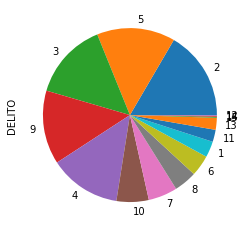

In [23]:
datos['DELITO'].value_counts(normalize=True).plot.pie()

Los tres crímenes más comunes fueron: el robo de accesorios, refacciones o herramientas de vehículo (2); seguido por el robo o asalto en la calle o transporte público (5); y en tercer lugar el vandalismo, o pinta de bardas en casas (3).

In [24]:
datos['LUGAR'].groupby(datos['DELITO']).value_counts()

DELITO  LUGAR
1       1        984
        2        155
        5         91
        4         81
        7         33
                ... 
15      4         16
        8          7
        7          5
        6          3
        9          1
Name: LUGAR, Length: 117, dtype: int64

En el caso de robo total de vehículo (1), los lugares más comúnes fueron: en la calle (1), seguido por las casas (2) y después por negocios o establecimientos comerciales (5).

In [25]:
X['EDAD'].groupby(X['SEXO']).value_counts(bins=5, normalize=True)

SEXO                
1     (17.919, 34.0]    0.439058
      (34.0, 50.0]      0.345446
      (50.0, 66.0]      0.162469
      (66.0, 82.0]      0.043889
      (82.0, 98.0]      0.009138
2     (17.919, 34.0]    0.441943
      (34.0, 50.0]      0.342307
      (50.0, 66.0]      0.156388
      (66.0, 82.0]      0.049433
      (82.0, 98.0]      0.009929
Name: EDAD, dtype: float64

Para ambos sexos, el grupo de edad con mayor nivel de victimización en el 2017 fue de entre los 18 y 34 años.

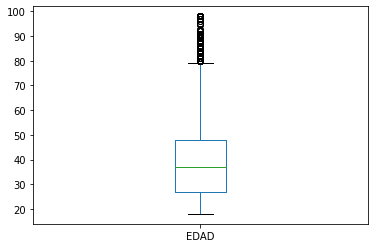

In [26]:
X['EDAD'].plot.box()

In [27]:
X['EDAD'].value_counts(sort=True).nlargest(5)

25    1385
32    1324
30    1323
28    1319
24    1300
Name: EDAD, dtype: int64

Más específicamente, las edades con un mayor número de víctimas son a los 25 años, a los 32, los 30, los 28 y los 24, respectivamente.

# Codificación ONE-HOT

In [28]:
#La columna 'DELITO' será la variable de salida 
target = datos['DELITO']
#Muestra de todos los posibles valores diferentes para 'target'
pd.unique(target)

array([ 2,  1, 11,  7,  5,  9,  8,  4,  3,  6, 10, 13, 14, 12, 15])

In [29]:
# (además, se transforma de pd.Series a np.array)
y = target.to_numpy(copy=False)
pd.unique(y)

array([ 2,  1, 11,  7,  5,  9,  8,  4,  3,  6, 10, 13, 14, 12, 15])

In [30]:
#para comparar
print(type(target))
print(type(y))
print(target.shape)
print(y.shape)
# print(target.shape[0])
# print(target.shape[1])

<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>
(46674,)
(46674,)


In [31]:
# Verificar que los datos sean int64
X.dtypes

SEXO      int64
EDAD      int64
MES       int64
ESTADO    int64
HORA      int64
LUGAR     int64
dtype: object

In [32]:
# Instancia
# Codificar etiquetas con valores entre 0 y {n_clases - 1}.
le = preprocessing.LabelEncoder()

# Ajuste y transformación
# usar df.apply() para aplicar le.fit_transform a todas las columnas
X2 = X.apply(le.fit_transform)
X2.head()
# type(X2)

,SEXO,EDAD,MES,ESTADO,HORA,LUGAR
0,0,13,3,0,3,0
1,0,13,9,0,2,0
2,0,13,4,0,1,0
3,0,13,4,0,2,0
4,0,13,5,0,0,0


In [33]:
# Instancia
enc = preprocessing.OneHotEncoder()

# Ajuste
enc.fit(X2)

# Transformación
X_onehotlabels = enc.transform(X2).toarray()

print(X_onehotlabels.shape)

(46674, 142)


In [34]:
print(" X es un array con {} atributos.".format(X.shape[1]))
print(" X_onehotlabels es un array con {} atributos.".format(X_onehotlabels.shape[1]))

 X es un array con 6 atributos.
 X_onehotlabels es un array con 142 atributos.


In [35]:
X_onehotlabels

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 1.]])

# Clasificación mediante una red neuronal densa, a través de la librería Keras

In [36]:
#se utiliza la funcion train_test_split para separar los datos aleatoriamente en cuatro sets: 
#dos de entrenamiento (75%) y otros dos de prueba (25%), tanto features como target

#generación de arreglos aleatorios de features y valores de salida de entrenamiento y de prueba
x_tr_one_hot, x_ts_one_hot, y_tr, y_ts = train_test_split(X_onehotlabels, y, test_size = 0.25, random_state = 42)

#cambiamos las variables al tipo numpy int
# y_tr = np.asarray(y_tr, dtype = np.int)   
# y_ts = np.asarray(y_ts, dtype = np.int)   

#reacomodamos el arreglo según el numero de valores en el dataset
y_tr = np.reshape( y_tr, [len(y_tr),1] )          
y_ts = np.reshape( y_ts, [len(y_ts),1] )          

print(x_ts_one_hot.shape)
print(x_tr_one_hot.shape)
print(y_ts.shape)
print(y_tr.shape)

(11669, 142)
(35005, 142)
(11669, 1)
(35005, 1)


In [37]:
y_ts_one_hot = tf.keras.utils.to_categorical(y_ts, dtype='int64')
y_tr_one_hot = tf.keras.utils.to_categorical(y_tr, dtype='int64')

print(y_ts_one_hot.shape)
print(y_tr_one_hot.shape)

(11669, 16)
(35005, 16)


In [38]:
#verificación
print(y_ts_one_hot)

[[0 0 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [39]:
#verificación
print(x_ts_one_hot)

[[0. 1. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


In [42]:
# Training Data
#reescalamos el dataframe de valores de entrenamiento como un arreglo de valores entre 0 y 1
x_tr_one_hot_norm = MinMaxScaler().fit_transform(x_tr_one_hot)     
y_tr_one_hot_norm = MinMaxScaler().fit_transform(y_tr_one_hot)            
print("Training Data :", x_tr_one_hot_norm.shape)

# Testing Data
#reescalamos el dataframe de valores de prueba como un arreglo de valores entre 0 y 1  
x_ts_one_hot_norm = MinMaxScaler().fit_transform(x_ts_one_hot)     
y_ts_one_hot_norm = MinMaxScaler().fit_transform(y_ts_one_hot)   
print("Testing Data :", x_ts_one_hot_norm.shape)

Training Data : (35005, 142)
Testing Data : (11669, 142)


In [43]:
#verificación
x_ts_one_hot_norm

array([[0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

Los hiperparametros a utilizar son: 
- factor de aprendizaje: variable en cada intento.
- funciones de activación: ReLU para las capas ocultas y Softmax para la capa de salida.
- función de error: categorical_cross_entropy

In [51]:
# Definición del modelo
def create_model(l_rate):
    model = tf.keras.Sequential()
    
    # Capas ocultas
    n_classes_input = x_tr_one_hot_norm.shape[1]
    n_classes_output = y_tr_one_hot_norm.shape[1]

    model.add(tf.keras.layers.Dense(20, input_dim=n_classes_input, activation='relu'))
    # model.add(Dropout(0.5))   # Activar en caso de ser necesario
    model.add(tf.keras.layers.Dense(15, input_dim=20,activation='relu'))

    # Capa de salida
    model.add(tf.keras.layers.Dense(n_classes_output, input_dim=15, activation='softmax'))

    # Compilar el modelo
    opt = keras.optimizers.Adam(learning_rate=l_rate)
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=opt)
    return model

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 20)                2860      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                315       
_________________________________________________________________
dense_5 (Dense)              (None, 16)                256       
Total params: 3,431
Trainable params: 3,431
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
274/274 [==============================] - 1s 3ms/step - loss: 1.9881 - accuracy: 0.3346 - val_loss: 1.6470 - val_accuracy: 0.4368
Epoch 2/100
274/274 [==============================] - 1s 2ms/step - loss: 1.6345 - accuracy: 0.4385 - val_loss: 1.6280 - val_accuracy: 0.4439
Epoch 3/100
274/274 [==============================] - 1s 2ms/step - loss: 1.5925 - accuracy: 0.

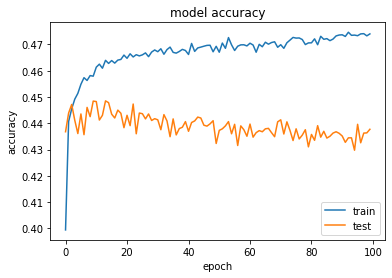

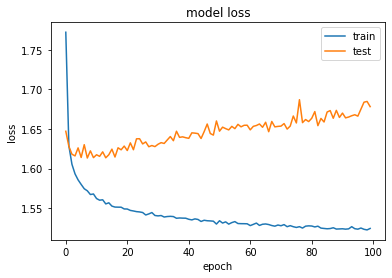

In [48]:
#Modelo con learning_rate=0.01
model = create_model(l_rate=0.01)
model.summary()


# Entrenamiento del modelo por 100 iteraciones 
results = model.fit(x_tr_one_hot_norm, y_tr_one_hot_norm, batch_size=128, epochs=100, validation_data=(x_ts_one_hot_norm, y_ts_one_hot_norm))


# summarize history for accuracy
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 20)                2860      
_________________________________________________________________
dense_7 (Dense)              (None, 15)                315       
_________________________________________________________________
dense_8 (Dense)              (None, 16)                256       
Total params: 3,431
Trainable params: 3,431
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
274/274 [==============================] - 1s 3ms/step - loss: 2.4891 - accuracy: 0.1663 - val_loss: 1.8154 - val_accuracy: 0.4162
Epoch 2/100
274/274 [==============================] - 1s 2ms/step - loss: 1.7478 - accuracy: 0.4253 - val_loss: 1.6768 - val_accuracy: 0.4293
Epoch 3/100
274/274 [==============================] - 1s 2ms/step - loss: 1.6525 - accuracy: 0.

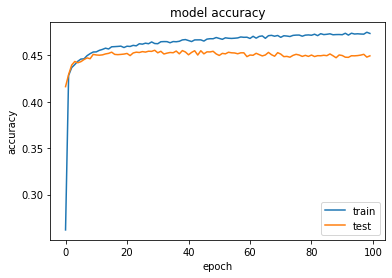

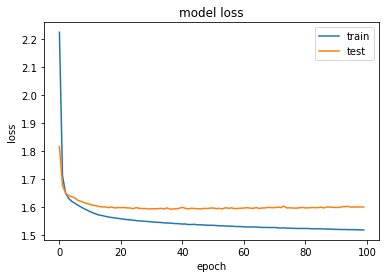

In [52]:
#Modelo con learning_rate=0.001
model = create_model(l_rate=0.001)
model.summary()


# Entrenamiento del modelo por 100 iteraciones 
results = model.fit(x_tr_one_hot_norm, y_tr_one_hot_norm, batch_size=128, epochs=100, validation_data=(x_ts_one_hot_norm, y_ts_one_hot_norm))


# summarize history for accuracy
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 20)                2860      
_________________________________________________________________
dense_10 (Dense)             (None, 15)                315       
_________________________________________________________________
dense_11 (Dense)             (None, 16)                256       
Total params: 3,431
Trainable params: 3,431
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
274/274 [==============================] - 1s 2ms/step - loss: 1.9688 - accuracy: 0.3386 - val_loss: 1.6448 - val_accuracy: 0.4445
Epoch 2/1000
274/274 [==============================] - 0s 2ms/step - loss: 1.6292 - accuracy: 0.4437 - val_loss: 1.6301 - val_accuracy: 0.4436
Epoch 3/1000
274/274 [==============================] - 0s 2ms/step - loss: 1.6043 - accuracy:

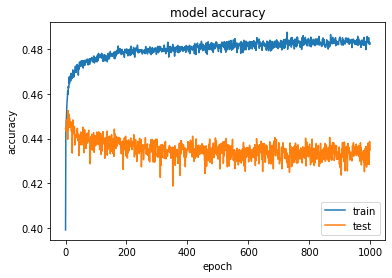

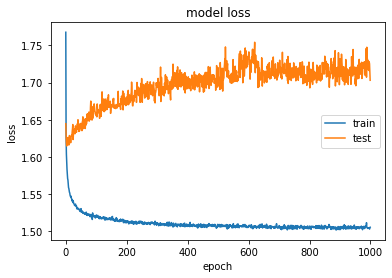

In [53]:
#Modelo con learning_rate=0.01
model = create_model(l_rate=0.01)
model.summary()


# Entrenamiento del modelo por 1000 iteraciones 
results = model.fit(x_tr_one_hot_norm, y_tr_one_hot_norm, batch_size=128, epochs=1000, validation_data=(x_ts_one_hot_norm, y_ts_one_hot_norm))


# summarize history for accuracy
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

- Para 100 iteraciones y learning_rate=0.01: \
Accuracy=0.4759   \
Loss=1.5230

- Para 100 iteraciones y learning_rate=0.001: \
Accuracy=0.4736  \
Loss=1.5151

- Para 1000 iteraciones y learning_rate=0.01: \
Accuracy=0.4846   \
Loss=1.4985

El accuracy presentó muy pocos cambios al disminuir el factor de aprendizaje, pero efectivamente mejoró en una pequeña cantidad al incrementar el número de iteraciones hasta 1000.

# Guardado y carga posterior del modelo

In [49]:
model.save('modelo_clasificacion_delitos.h5')

In [50]:
from keras.models import load_model
pretrained_model = load_model('modelo_clasificacion_delitos.h5')

# Conclusión

Esta red neuronal podría tener una potencial aplicación en la predicción de la victimización. Más específicamente y por poner un ejemplo: si una persona de cierto sexo y edad, de un estado en particular, planea salir a la calle a un lugar específico, a cierta hora y en cierto mes del año, debería ser capaz de conocer (a través de una aplicación web o móvi) predicciones sobre los posibles crímenes a los que se expone, para poder tomar mejores decisiones en base a ello.

Por supuesto, el modelo de clasificación que aquí se presenta tiene muchas limitaciones y aún no está capacitado para hacer predicciones de valor práctico. Es necesario hacer consideraciones posteriores para aumentar progresivamente el realismo del problema. Por ejemplo, se podría concentrar la información a un solo estado, o a un solo municipio; podría estudiarse también el efecto que tienen los valores en los que la respuesta del encuestado fue "No sabe/ No recuerda/ No definida"; entre otras muchas asunciones.
Sin duda, este modelo podría enriquecerse en gran medida si se colabora con especialistas de otras áreas, como criminólogos, psicólogos, etc.

# Fuentes

- *Encuesta Nacional de Victimización y Percepción sobre Seguridad Pública 2018. ENVIPE. Marco conceptual.* Instituto Nacional de Estadísticas y Geografía (INEGI). Recuperado desde:
https://www.inegi.org.mx/app/biblioteca/ficha.html?upc=702825104818

- *Get Started: 3 Ways to Load CSV files into Colab*. Towards Data Science. Tomado desde:
https://towardsdatascience.com/3-ways-to-load-csv-files-into-colab-7c14fcbdcb92

- *Valuable Data Analysis with Pandas Value Counts*. Sharon McCutcheon. Towards Data Science. Recuperado de:
https://towardsdatascience.com/valuable-data-analysis-with-pandas-value-counts-d87bbdf42f79

